In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score, accuracy_score

### Data Loading and Processing (Adapt for your dataset)

In [ ]:
class NucleiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(128, 128)):
        self.image_size = image_size
        self.image_paths = []
        self.mask_paths = []
        self.image_filenames = []
        image_files = sorted(os.listdir(image_dir))
        mask_files = sorted(os.listdir(mask_dir))

        for img_file, mask_file in zip(image_files, mask_files):
            img_path = os.path.join(image_dir, img_file)
            mask_path = os.path.join(mask_dir, mask_file)
            self.image_paths.append(img_path)
            self.mask_paths.append(mask_path)
            self.image_filenames.append(img_file)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        img_filename = self.image_filenames[idx]

        img = io.imread(img_path)
        mask = io.imread(mask_path)

        if img.ndim == 3 and img.shape[2] == 4:
            img = img[:, :, :3]  # Drop alpha if RGBA

        if mask.ndim == 3:
            if mask.shape[2] == 4:
                mask = mask[:, :, :3]
            mask = color.rgb2gray(mask)
        elif mask.ndim == 2:
            pass  # already grayscale

        img_resized = resize(img, self.image_size, anti_aliasing=True)
        if img_resized.ndim == 3:
            img_gray = color.rgb2gray(img_resized)
        else:
            img_gray = img_resized

        mask_resized = resize(mask, self.image_size, anti_aliasing=True)
        mask_binary = mask_resized > 0.5

        return torch.tensor(np.expand_dims(img_gray.astype(np.float32), axis=0)).to(device), \
               torch.tensor(np.expand_dims(mask_binary.astype(np.float32), axis=0)).to(device), \
               resize(img, self.image_size, anti_aliasing=True), \
               resize(mask, self.image_size, anti_aliasing=True), \
               img_filename

### Hybrid Attention Module (HAM)

In [ ]:
class HybridAttention(nn.Module):
    def __init__(self, in_channels):
        super(HybridAttention, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1).to(device),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, in_channels, kernel_size=1).to(device),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1).to(device),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, 1, kernel_size=3, padding=1).to(device),
            nn.Sigmoid()
        )

    def forward(self, x):
        channel_attn = self.channel_attention(x)
        spatial_attn = self.spatial_attention(x)
        channel_refined = x * channel_attn
        spatial_refined = x * spatial_attn
        # Novel combination: Element-wise multiplication of channel and spatial refined features
        attention_out = channel_refined * spatial_refined
        return x + attention_out

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels_1x1, red_channels_3x3, out_channels_3x3, red_channels_5x5, out_channels_5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_channels_1x1, kernel_size=1).to(device)
        self.branch2_red = nn.Conv2d(in_channels, red_channels_3x3, kernel_size=1).to(device)
        self.branch2_conv = nn.Conv2d(red_channels_3x3, out_channels_3x3, kernel_size=3, padding=1).to(device)
        self.branch3_red = nn.Conv2d(in_channels, red_channels_5x5, kernel_size=1).to(device)
        self.branch3_conv = nn.Conv2d(red_channels_5x5, out_channels_5x5, kernel_size=5, padding=2).to(device)
        self.branch4_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch4_proj = nn.Conv2d(in_channels, pool_proj, kernel_size=1).to(device)

    def forward(self, x):
        branch1_out = F.relu(self.branch1(x))
        branch2_out = F.relu(self.branch2_conv(F.relu(self.branch2_red(x))))
        branch3_out = F.relu(self.branch3_conv(F.relu(self.branch3_red(x))))
        branch4_out = F.relu(self.branch4_proj(self.branch4_pool(x)))
        outputs = [branch1_out, branch2_out, branch3_out, branch4_out]
        return torch.cat(outputs, 1)

class HMSAModule(nn.Module):
    def __init__(self, in_channels, out_channels_1x1, red_channels_3x3, out_channels_3x3, red_channels_5x5, out_channels_5x5, pool_proj):
        super(HMSAModule, self).__init__()
        self.inception = InceptionModule(in_channels, out_channels_1x1, red_channels_3x3, out_channels_3x3, red_channels_5x5, out_channels_5x5, pool_proj).to(device)
        inception_output_channels = out_channels_1x1 + out_channels_3x3 + out_channels_5x5 + pool_proj
        self.attention = HybridAttention(inception_output_channels).to(device)
        if inception_output_channels != in_channels:
            self.projection = nn.Conv2d(inception_output_channels, in_channels, kernel_size=1).to(device)
        else:
            self.projection = None

    def forward(self, x):
        inception_out = self.inception(x)
        attention_out = self.attention(inception_out)
        if self.projection is not None:
            attention_out = self.projection(attention_out)
        hmsam_output = x + attention_out
        return hmsam_output

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False).to(device)
        self.bn1 = nn.BatchNorm2d(out_ch).to(device)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False).to(device)
        self.bn2 = nn.BatchNorm2d(out_ch).to(device)
        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False).to(device),
                nn.BatchNorm2d(out_ch).to(device)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class UpSample(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2).to(device)

    def forward(self, x):
        return self.up(x)

### HMSAM-UNet Model

In [ ]:
class HMSAM_ResUNet(nn.Module):
    def __init__(self, num_channels=1, out_channels=1):
        super(HMSAM_ResUNet, self).__init__()

        self.enc1_res1 = ResidualBlock(num_channels, 64)
        self.enc1_res2 = ResidualBlock(64, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2_res1 = ResidualBlock(64, 128)
        self.enc2_res2 = ResidualBlock(128, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3_res1 = ResidualBlock(128, 256)
        self.enc3_res2 = ResidualBlock(256, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4_res1 = ResidualBlock(256, 512)
        self.enc4_res2 = ResidualBlock(512, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.hmsam = HMSAModule(in_channels=512,
                                    out_channels_1x1=128,
                                    red_channels_3x3=96, out_channels_3x3=192,
                                    red_channels_5x5=32, out_channels_5x5=64,
                                    pool_proj=128)

        self.up4 = UpSample(512, 512)
        self.dec4_res1 = ResidualBlock(512 + 512, 512)
        self.dec4_res2 = ResidualBlock(512, 512)

        self.up3 = UpSample(512, 256)
        self.dec3_res1 = ResidualBlock(256 + 256, 256)
        self.dec3_res2 = ResidualBlock(256, 256)

        self.up2 = UpSample(256, 128)
        self.dec2_res1 = ResidualBlock(128 + 128, 128)
        self.dec2_res2 = ResidualBlock(128, 128)

        self.up1 = UpSample(128, 64)
        self.dec1_res1 = ResidualBlock(64 + 64, 64)
        self.dec1_res2 = ResidualBlock(64, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1).to(device)

    def forward(self, x):
        # Encoder
        e1 = self.enc1_res2(self.enc1_res1(x))
        p1 = self.pool1(e1)

        e2 = self.enc2_res2(self.enc2_res1(p1))
        p2 = self.pool2(e2)

        e3 = self.enc3_res2(self.enc3_res1(p2))
        p3 = self.pool3(e3)

        e4 = self.enc4_res2(self.enc4_res1(p3))
        bridge = self.pool4(e4)

        hmsam_out = self.hmsam(bridge)

        # Decoder
        up4 = self.up4(hmsam_out)
        d4 = self.dec4_res2(self.dec4_res1(torch.cat([up4, e4], dim=1)))

        up3 = self.up3(d4)
        d3 = self.dec3_res2(self.dec3_res1(torch.cat([up3, e3], dim=1)))

        up2 = self.up2(d3)
        d2 = self.dec2_res2(self.dec2_res1(torch.cat([up2, e2], dim=1)))

        up1 = self.up1(d2)
        d1 = self.dec1_res2(self.dec1_res1(torch.cat([up1, e1], dim=1)))

        return torch.sigmoid(self.final(d1))

### Training

In [ ]:
def train_unet(model, train_loader, num_epochs=10, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for img_tensor, mask_tensor, _, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            img_tensor, mask_tensor = img_tensor.to(device), mask_tensor.to(device)
            optimizer.zero_grad()
            output = model(img_tensor)
            loss = criterion(output, mask_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")
    return model

### Prediction

In [ ]:
def predict_unet(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    predictions = []
    original_images = []
    ground_truth_masks = []
    image_filenames = []
    with torch.no_grad():
        for img_tensor, mask_tensor, original_img, original_mask, filename in tqdm(test_loader, desc="Predicting"):
            img_tensor = img_tensor.to(device)
            output = model(img_tensor).cpu().numpy()
            predictions.append((output[0], filename[0]))
            original_images.extend(original_img)
            ground_truth_masks.extend(original_mask)
            image_filenames.extend(filename)
    return predictions, original_images, ground_truth_masks, image_filenames

### Evaluation

In [ ]:
def evaluate_predictions(predictions, gt_masks):
    dice_scores = []
    iou_scores = []
    precisions = []
    recalls = []
    accuracies = []

    for pred_mask, fname in predictions:
        gt_mask = gt_masks.get(fname)
        if gt_mask is None:
            print(f"Ground truth for {fname} not found.")
            continue

        pred_mask_binary = (pred_mask > 0.5).flatten().astype(np.uint8)
        gt_mask_array = gt_mask.cpu().numpy()
        gt_mask_binary = (gt_mask_array > 0.5).flatten().astype(np.uint8)

        dice = f1_score(gt_mask_binary, pred_mask_binary)
        iou = jaccard_score(gt_mask_binary, pred_mask_binary)
        precision = precision_score(gt_mask_binary, pred_mask_binary, zero_division=0)
        recall = recall_score(gt_mask_binary, pred_mask_binary, zero_division=0)
        accuracy = accuracy_score(gt_mask_binary, pred_mask_binary)

        dice_scores.append(dice)
        iou_scores.append(iou)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)

    print("\nEvaluation Metrics:")
    print(f"Dice Score (F1):  {np.mean(dice_scores):.4f}")
    print(f"IoU Score:        {np.mean(iou_scores):.4f}")
    print(f"Precision:        {np.mean(precisions):.4f}")
    print(f"Recall:           {np.mean(recalls):.4f}")
    print(f"Accuracy:         {np.mean(accuracies):.4f}")

### Visualization

In [ ]:
def visualize_results(original_images, ground_truth_masks, predictions, num_samples=5, save_dir='results/hmsam_unet'):
    os.makedirs(save_dir, exist_ok=True)
    for i in range(min(num_samples, len(original_images))):
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        if original_images[i].ndim == 3:
            plt.imshow(original_images[i])
        else:
            plt.imshow(original_images[i], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(1, 3, 2)
        if ground_truth_masks[i].ndim == 3:
            plt.imshow(ground_truth_masks[i])
        else:
            plt.imshow(ground_truth_masks[i], cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Prediction (binarized output)
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i][0] > 0.5, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.savefig(os.path.join(save_dir, f'prediction_result_{i}.png'))
        plt.close()

### Main Execution

cuda


Epoch 1/1: 100%|██████████| 168/168 [08:27<00:00,  3.02s/it]


Epoch 1/1, Loss: 0.2281


Predicting: 100%|██████████| 55/55 [01:19<00:00,  1.45s/it]



Evaluation Metrics:
Dice Score (F1):  0.0438
IoU Score:        0.0354
Precision:        0.0909
Recall:           0.0355
Accuracy:         0.8802


TypeError: Invalid shape (1, 128, 128) for image data

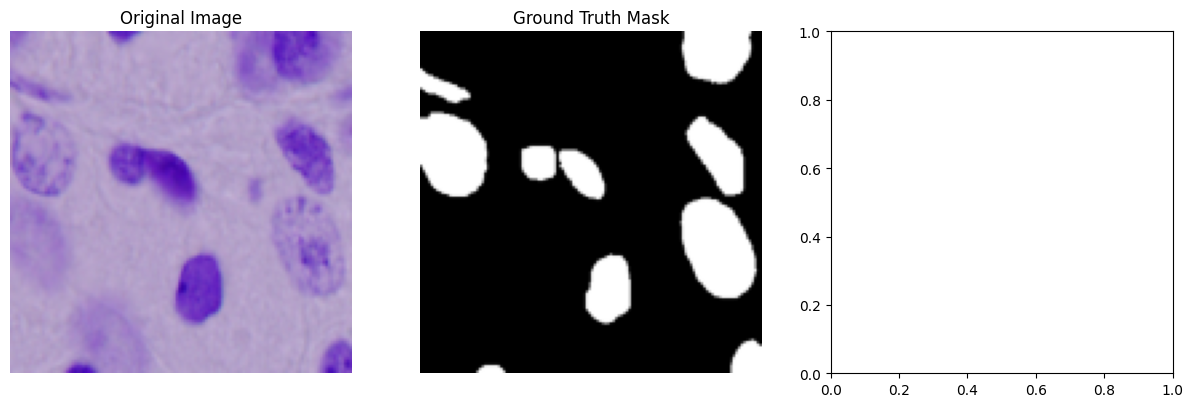

In [ ]:
if __name__ == '__main__':
    train_image_dir = '/content/drive/MyDrive/NucleiSegmentation/NucleiSegmentationDataset/all_images'
    train_mask_dir = '/content/drive/MyDrive/NucleiSegmentation/NucleiSegmentationDataset/merged_masks'
    test_image_dir = '/content/drive/MyDrive/NucleiSegmentation/TestDataset/images'
    test_mask_dir = '/content/drive/MyDrive/NucleiSegmentation/TestDataset/masks'
    # train_image_dir = '/content/drive/MyDrive/NucleiSegmentation/TestDataset/images'
    # train_mask_dir = '/content/drive/MyDrive/NucleiSegmentation/TestDataset/masks'

    train_dataset = NucleiDataset(train_image_dir, train_mask_dir)
    test_dataset = NucleiDataset(test_image_dir, test_mask_dir)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    hmsam_unet_model = HMSAM_ResUNet(num_channels=1, out_channels=1)

    hmsam_unet_model = train_unet(hmsam_unet_model, train_loader, num_epochs=1, lr=0.001) # Reduced epochs for quicker test

    predictions, original_test_images, original_test_masks, test_filenames = predict_unet(hmsam_unet_model, test_loader)


    gt_masks_for_eval = {}
    for mask, filename in zip(original_test_masks, test_filenames):
        gt_masks_for_eval[filename] = mask

    evaluate_predictions(predictions, gt_masks_for_eval)
    visualize_results(original_test_images, original_test_masks, predictions, num_samples=55)